### Настройка параметров и выбор модели 

#### Импорт модулей

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import joblib
import warnings
from sklearn.metrics import balanced_accuracy_score, roc_auc_score,roc_curve,confusion_matrix,plot_confusion_matrix,classification_report,precision_score,recall_score,f1_score,accuracy_score,plot_roc_curve, confusion_matrix
warnings.filterwarnings('ignore')

#### Читаем датасеты

In [54]:
train = pd.read_csv('transform_train.csv')
test = pd.read_csv('transform_test.csv')

In [55]:
x_train = train.drop(columns=['Churn'])
y_train = train['Churn']
x_test = test.drop(columns=['Churn'])
y_test = test['Churn']

#### В проекте будем использовать следующие модели:
- Логистическая регрессия - вероятность входа в определенный класс
- Дерево решений - используя древовидную модель, покажем возможные последствия решения
- Случайный лес - случайным образом создает и объединяет несколько деревьев решений 

#### Создаем и обучаем модели

In [56]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

In [57]:
lr.fit(x_train,y_train)
dt.fit(x_train,y_train)
rf.fit(x_train,y_train)

RandomForestClassifier()

#### Кросс-валидация

In [58]:
log_cv_0 = cross_val_score(lr,x_train,y_train,cv=5)*100
tree_cv_0 = cross_val_score(dt,x_train,y_train,cv=5)*100
forest_cv_0 = cross_val_score(rf,x_train,y_train,cv=5)*100

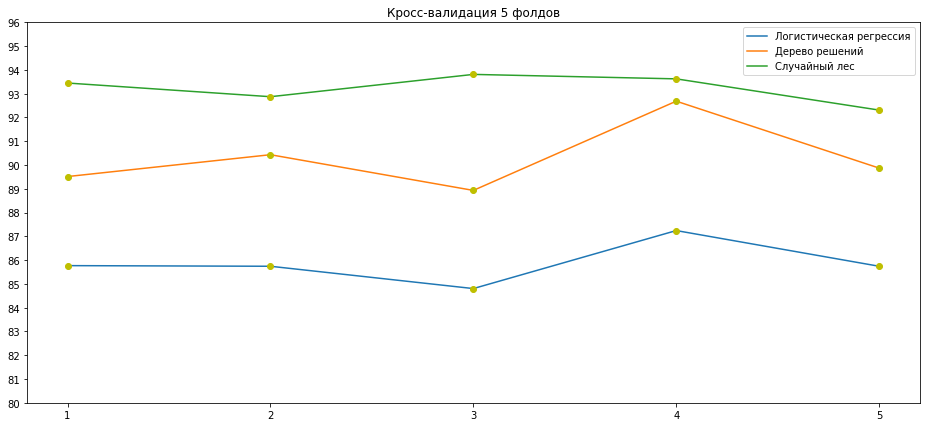

In [59]:
plt.figure(figsize=(16,7))
plt.title('Кросс-валидация 5 фолдов')
plt.plot([1,2,3,4,5],log_cv_0)
plt.plot([1,2,3,4,5],tree_cv_0)
plt.plot([1,2,3,4,5],forest_cv_0)
plt.plot([1,2,3,4,5],log_cv_0,'yo')
plt.plot([1,2,3,4,5],tree_cv_0,'yo')
plt.plot([1,2,3,4,5],forest_cv_0,'yo')
plt.legend(['Логистическая регрессия','Дерево решений','Случайный лес'])
plt.xticks(np.arange(1,6))
plt.yticks(np.arange(80,97,1))
plt.show()

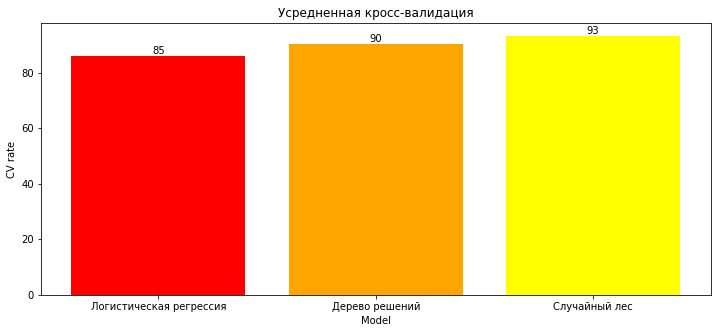

In [60]:
plt.figure(figsize=(12,5))
plt.title('Усредненная кросс-валидация')
plot = plt.bar(['Логистическая регрессия','Дерево решений','Случайный лес'],[log_cv_0.mean(),tree_cv_0.mean(),forest_cv_0.mean()],color=['red','orange','yellow'])
plt.ylabel('CV rate')
plt.xlabel('Model')
for i in plot:
    height = i.get_height()
    plt.text(i.get_x() + i.get_width()/2.,
             1.002*height,'%d'% int(height),ha='center',va='bottom' )
plt.show()

#### Тюнинг гиперпараметров

Изменяя параметр модели на определенное значение, мы надеемся, что производительность нашей модели может улучшиться при классификации скорости перемешивания.

В этом проекте для экономии времени будет использоваться RandomizedSearch вместо GridSearch. 

In [61]:
def tuning(model,parameter,n_cv):
    random = RandomizedSearchCV(model, parameter, cv = n_cv)
    random.fit(x_train,y_train)
    best_param = random.best_params_
    
    return best_param

#### Параметр логистической регрессии
Проверяемый параметр:

- solver
- max iteration

In [62]:
log_param = {
    'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
    'penalty':['none','l1','l2','elasticnet'],
    'C':[100,10,1.0,0.1,0.01]
}

log_best = tuning(lr,log_param,5)

#### Параметр для дерева решений
Проверяемый параметр:

- criterion - выбрать лучший срез в дереве решений
- max_depths - длина дерева (от корня до листа) 

In [63]:
tree_param = {
    'max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features':['sqrt','log2'],
    'min_samples_split': [i for i in range(2,21,2)],
    'min_samples_leaf': [i for i in range(1,12)],
    'criterion':['gini','entropy']
}

tree_best = tuning(dt,tree_param,5)

#### Параметр для случайного леса
Проверяемый параметр:

- n_estimators - количество деревьев в лесу
- min_sample_split - минимальное количество выборок, необходимых для разделения внутреннего узла / условия.
- min_samples_leaf - минимальное количество выборок, необходимых для конечного узла / конца. 

In [76]:
forest_param = {
    'n_estimators': [100,200,300,400,500],
    'min_samples_split': [i for i in range(2,21,2)],
    'min_samples_leaf': [i for i in range(1,12)],
    'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['sqrt','log2'],
    'criterion':['gini','entropy']
}

forest_best = tuning(rf,forest_param,5)

### Лучшие параметры из RandomizedSearch

In [65]:
print(log_best)

{'solver': 'newton-cg', 'penalty': 'none', 'C': 0.01}


In [66]:
log_new = LogisticRegression(solver='newton-cg',penalty='none',C=0.01)
log_new.fit(x_train,y_train)

LogisticRegression(C=0.01, penalty='none', solver='newton-cg')

In [67]:
print(tree_best)

{'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 60, 'criterion': 'gini'}


In [68]:
tree_new = DecisionTreeClassifier(min_samples_split=14,min_samples_leaf=4,max_features='sqrt',max_depth=60,criterion='gini')
tree_new.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=60, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=14)

In [77]:
print(forest_best)

{'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 40, 'criterion': 'gini'}


In [78]:
forest_new = RandomForestClassifier(n_estimators=300,min_samples_split=4,min_samples_leaf=3,max_features='sqrt',max_depth=40,criterion='gini')
forest_new.fit(x_train,y_train)

RandomForestClassifier(max_depth=40, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=4, n_estimators=300)

#### Сравнение параметров по умолчанию с результатом настройки гиперпараметров 

In [71]:
log_acc_0 = round(lr.score(x_test,y_test)*100,2)
log_acc_1 = round(log_new.score(x_test,y_test)*100,2)

print('Точность логистической регрессии с параметрами по умолчанию',log_acc_0,'%')
print('Точность логистической регрессии после тюнинга гиперпараметров',log_acc_1,'%')
print('После тюнинга гиперпараметров точность увеличилась на',round(log_acc_1-log_acc_0,2),'%')

Точность логистической регрессии с параметрами по умолчанию 84.26 %
Точность логистической регрессии после тюнинга гиперпараметров 86.06 %
После тюнинга гиперпараметров точность увеличилась на 1.8 %


In [72]:
tree_acc_0 = round(dt.score(x_test,y_test)*100,2)
tree_acc_1 = round(tree_new.score(x_test,y_test)*100,2)

print('Точность дерева принятия решений с параметрами по умолчанию',tree_acc_0,'%')
print('Точность дерева принятия решений после тюнинга гиперпараметров',tree_acc_1,'%')
print('После тюнинга гиперпараметров точность увеличилась на',round(tree_acc_1-tree_acc_0,2),'%')

Точность дерева принятия решений с параметрами по умолчанию 91.6 %
Точность дерева принятия решений после тюнинга гиперпараметров 87.56 %
После тюнинга гиперпараметров точность увеличилась на -4.04 %


In [79]:
forest_acc_0 = round(rf.score(x_test,y_test)*100,2)
forest_acc_1 = round(forest_new.score(x_test,y_test)*100,2)

print('Точность случайного леса с параметрами по умолчанию',forest_acc_0,'%')
print('Точность случайного леса после тюнинга гиперпараметров',forest_acc_1,'%')
print('После тюнинга гиперпараметров точность увеличилась на',round(forest_acc_1-forest_acc_0,2),'%')

Точность случайного леса с параметрами по умолчанию 93.85 %
Точность случайного леса после тюнинга гиперпараметров 93.55 %
После тюнинга гиперпараметров точность увеличилась на -0.3 %


### Сравнение модели после тюнинга гиперпараметров

#### Кросс-валидация

In [80]:
log_cv_1 = cross_val_score(log_new,x_train,y_train,cv=5)*100
tree_cv_1 = cross_val_score(tree_new,x_train,y_train,cv=5)*100
forest_cv_1 = cross_val_score(forest_new,x_train,y_train,cv=5)*100

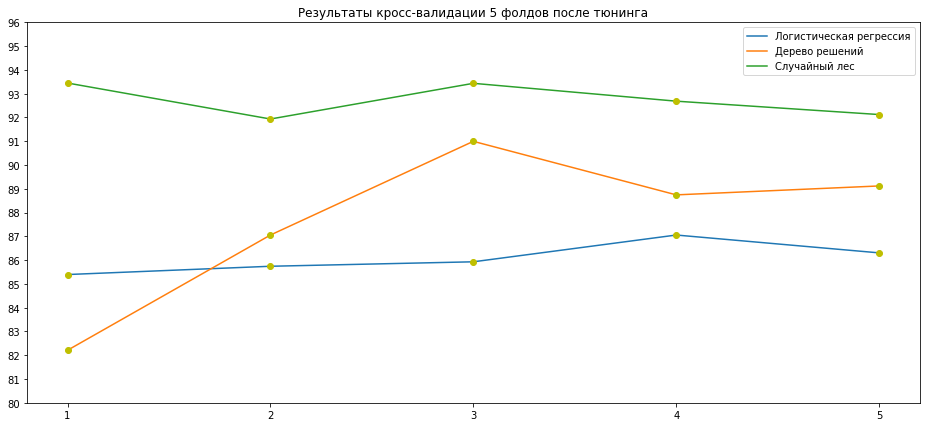

In [81]:
plt.figure(figsize=(16,7))
plt.title('Результаты кросс-валидации 5 фолдов после тюнинга')
plt.plot([1,2,3,4,5],log_cv_1)
plt.plot([1,2,3,4,5],tree_cv_1)
plt.plot([1,2,3,4,5],forest_cv_1)
plt.plot([1,2,3,4,5],log_cv_1,'yo')
plt.plot([1,2,3,4,5],tree_cv_1,'yo')
plt.plot([1,2,3,4,5],forest_cv_1,'yo')
plt.legend(['Логистическая регрессия','Дерево решений','Случайный лес'])
plt.xticks(np.arange(1,6))
plt.yticks(np.arange(80,97,1))
plt.show()

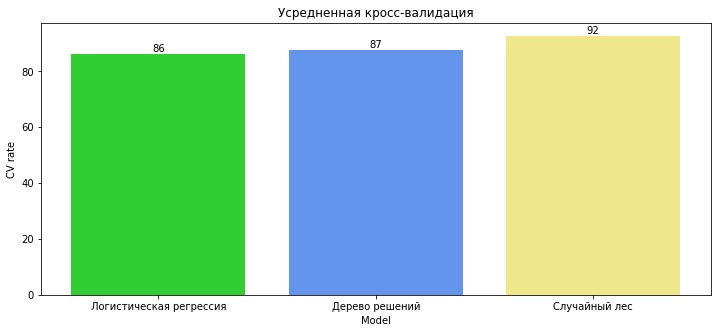

In [82]:
plt.figure(figsize=(12,5))
plt.title('Усредненная кросс-валидация')
plot = plt.bar(['Логистическая регрессия','Дерево решений','Случайный лес'],[log_cv_1.mean(),tree_cv_1.mean(),forest_cv_1.mean()],color=['limegreen','cornflowerblue','khaki'])
plt.ylabel('CV rate')
plt.xlabel('Model')
for i in plot:
    height = i.get_height()
    plt.text(i.get_x() + i.get_width()/2.,
             1.002*height,'%d'% int(height),ha='center',va='bottom' )
plt.show()

### Матрица ошибок

#### Логистическая регрессия

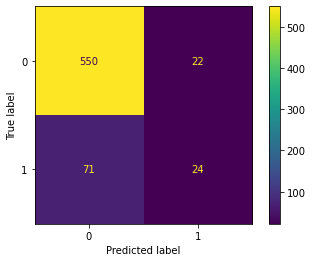

In [83]:
plot_confusion_matrix(log_new,x_test,y_test,values_format='0.0f')
plt.show()

#### Дерево принятия решений

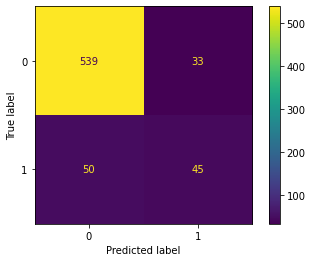

In [84]:
plot_confusion_matrix(tree_new,x_test,y_test,values_format='0.0f')
plt.show()

#### Случайный лес

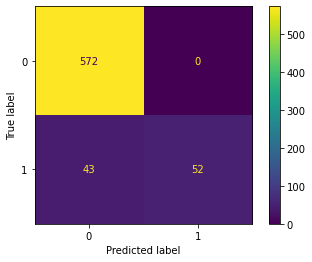

In [85]:
plot_confusion_matrix(forest_new,x_test,y_test,values_format='0.0f')
plt.show()

### Таблица результатов классификации

In [86]:
print('Classification report logistic regression:\n',classification_report(y_test,log_new.predict(x_test)))
print('Classification report Decision tree classifier:\n',classification_report(y_test,tree_new.predict(x_test)))
print('Classification report random forest classifier:\n',classification_report(y_test,forest_new.predict(x_test)))

Classification report logistic regression:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92       572
           1       0.52      0.25      0.34        95

    accuracy                           0.86       667
   macro avg       0.70      0.61      0.63       667
weighted avg       0.83      0.86      0.84       667

Classification report Decision tree classifier:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       572
           1       0.58      0.47      0.52        95

    accuracy                           0.88       667
   macro avg       0.75      0.71      0.72       667
weighted avg       0.87      0.88      0.87       667

Classification report random forest classifier:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       572
           1       1.00      0.55      0.71        95

    accuracy                           0

### Recall

Recall positive (sensitivity): $\displaystyle \frac {TP} {TP + FN}$

Recall negative (specificity): $\displaystyle \frac {TN} {TN + FP}$

In [87]:
log_recall_pos = recall_score(y_test,log_new.predict(x_test),pos_label=1)
log_recall_neg = recall_score(y_test,log_new.predict(x_test),pos_label = 0)
tree_recall_pos = recall_score(y_test,tree_new.predict(x_test),pos_label=1)
tree_recall_neg = recall_score(y_test,tree_new.predict(x_test),pos_label = 0)
forest_recall_pos = recall_score(y_test,forest_new.predict(x_test),pos_label=1)
forest_recall_neg = recall_score(y_test,forest_new.predict(x_test),pos_label = 0)

In [88]:
pd.DataFrame({'Logistic':[log_recall_pos,log_recall_neg],'Decision Tree':[tree_recall_pos,tree_recall_neg],'Random Forest':[forest_recall_pos,forest_recall_neg]},index=['churn','non churn'])

,Logistic,Decision Tree,Random Forest
churn,0.252632,0.473684,0.547368
non churn,0.961538,0.942308,1.000000


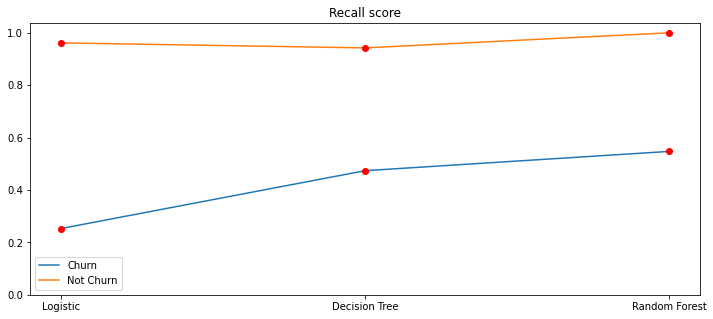

In [89]:
plt.figure(figsize=(12,5))
plt.title('Recall score')
plt.plot(['Logistic','Decision Tree','Random Forest'],[log_recall_pos,tree_recall_pos,forest_recall_pos])
plt.plot(['Logistic','Decision Tree','Random Forest'],[log_recall_neg,tree_recall_neg,forest_recall_neg])
plt.legend(['Churn','Not Churn'])
plt.plot([log_recall_pos,tree_recall_pos,forest_recall_pos],'ro')
plt.plot([log_recall_neg,tree_recall_neg,forest_recall_neg],'ro')
plt.yticks(np.arange(0,1.2,0.2))
plt.show()

### Precision


Formula Precision Positive = $\displaystyle \frac {TP}{TP+FP}$ 

Formula Precision Negative = $ \displaystyle \frac {TN}{TN+FN}$ 

In [90]:
log_prec_pos = precision_score(y_test,log_new.predict(x_test),pos_label=1)
log_prec_neg = precision_score(y_test,log_new.predict(x_test),pos_label=0)
tree_prec_pos = precision_score(y_test,tree_new.predict(x_test),pos_label=1)
tree_prec_neg = precision_score(y_test,tree_new.predict(x_test),pos_label=0)
forest_prec_pos = precision_score(y_test,forest_new.predict(x_test),pos_label=1)
forest_prec_neg = precision_score(y_test,forest_new.predict(x_test),pos_label=0)

In [91]:
pd.DataFrame({'Logistic':[log_prec_pos,log_prec_neg],'Decision Tree':[tree_prec_pos,tree_prec_neg],'Random Forest':[forest_prec_pos,forest_prec_neg]},index=['churn','non churn'])

,Logistic,Decision Tree,Random Forest
churn,0.521739,0.576923,1.000000
non churn,0.885668,0.915110,0.930081


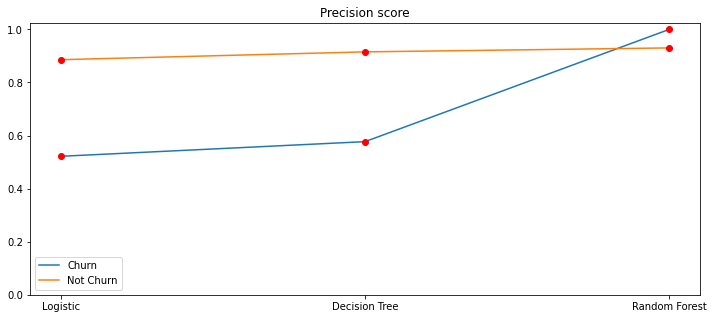

In [92]:
plt.figure(figsize=(12,5))
plt.title('Precision score')
plt.plot(['Logistic','Decision Tree','Random Forest'],[log_prec_pos,tree_prec_pos,forest_prec_pos])
plt.plot(['Logistic','Decision Tree','Random Forest'],[log_prec_neg,tree_prec_neg,forest_prec_neg])
plt.legend(['Churn','Not Churn'])
plt.plot([log_prec_pos,tree_prec_pos,forest_prec_pos],'ro')
plt.plot([log_prec_neg,tree_prec_neg,forest_prec_neg],'ro')
plt.yticks(np.arange(0,1.2,0.2))
plt.show()

##### Случайный лес дал более точный прогноз

### F1 Score

Formula = $\displaystyle 2 * (\frac {PrecisionP * RecallP }{PrecisionP + RecallP})$

In [93]:
f1_log_pos = f1_score(y_test,log_new.predict(x_test),pos_label=1)
f1_tree_pos = f1_score(y_test,tree_new.predict(x_test),pos_label=1)
f1_forest_pos = f1_score(y_test,forest_new.predict(x_test),pos_label=1)
f1_log_neg = f1_score(y_test,log_new.predict(x_test),pos_label=0)
f1_tree_neg = f1_score(y_test,tree_new.predict(x_test),pos_label=0)
f1_forest_neg = f1_score(y_test,forest_new.predict(x_test),pos_label=0)

In [94]:
pd.DataFrame({'Logistic':[f1_log_pos,f1_log_neg],'Decision Tree':[f1_tree_pos,f1_tree_neg],'Random Forest':[f1_forest_pos,f1_forest_neg]},index=['churn','not churn'])

,Logistic,Decision Tree,Random Forest
churn,0.340426,0.520231,0.707483
not churn,0.922045,0.928510,0.963774


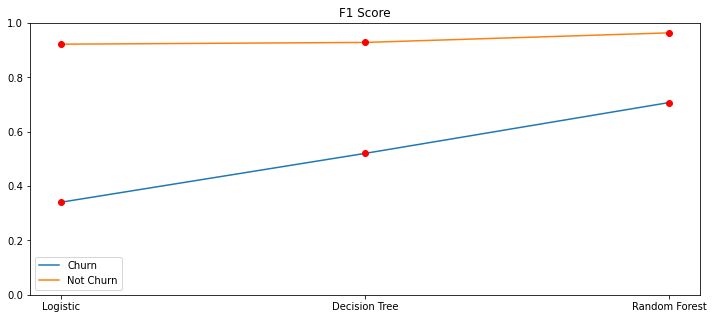

In [95]:
plt.figure(figsize=(12,5))
plt.title('F1 Score')
plt.plot(['Logistic','Decision Tree','Random Forest'],[f1_log_pos,f1_tree_pos,f1_forest_pos])
plt.plot(['Logistic','Decision Tree','Random Forest'],[f1_log_neg,f1_tree_neg,f1_forest_neg])
plt.plot([f1_log_pos,f1_tree_pos,f1_forest_pos],'ro')
plt.plot([f1_log_neg,f1_tree_neg,f1_forest_neg],'ro')
plt.yticks(np.arange(0,1.2,0.2))
plt.legend(['Churn','Not Churn'])
plt.show()

##### Логистическая регрессия показала худший результат по F1

### ROC AUC Score

Показывает, насколько модель способна различать классы. 

TPR = $\displaystyle \frac {TP}{TP+FN}$

FPR = $\displaystyle \frac {FP}{FP+TN}$

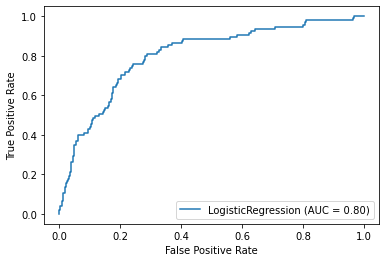

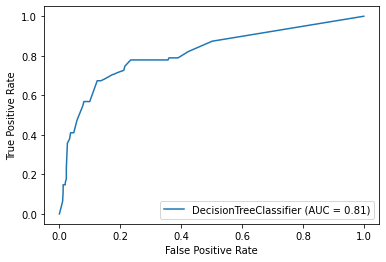

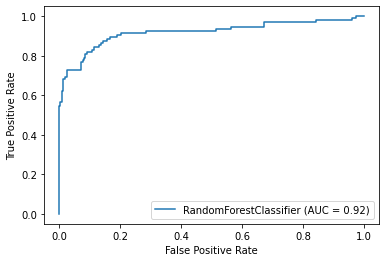

In [96]:
plot_roc_curve(log_new,x_test,y_test), plot_roc_curve(tree_new,x_test,y_test),plot_roc_curve(forest_new,x_test,y_test)
plt.show()

#### Анализ всех метрик показал, что для данной задачи лучше всего подходит случайный лес

#### Топ фичей по важности

In [97]:
importance = pd.Series(forest_new.feature_importances_,x_train.columns).sort_values(ascending=False)
top10 = importance.head(10)*100
top10

Day_charge        25.351630
CS_calls          15.034002
Eve_charge         7.007711
Intl_charge        6.954931
intl_Yes           6.788997
Intl_call          6.296479
intl_No            6.210318
Night_charge       4.582628
Day_call           3.715056
Account_length     3.704367
dtype: float64

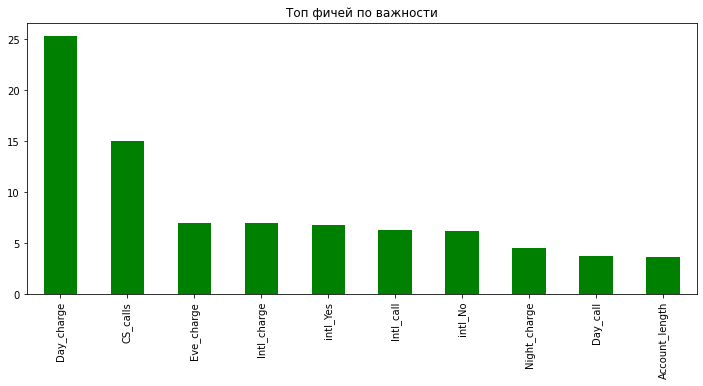

In [98]:
plt.figure(figsize=(12,5))
plt.title('Топ фичей по важности')
top10.plot(kind='bar',color=['green'])
plt.show()

Дневная оплата является наиболее определяющим фактором ухода клиентов, за которым следуют звонки в службу поддержки клиентов.

Многие уходящие клиенты считают, что дневная оплата компании слишком высока по сравнению с другими сетями.
Клиенты с большим количеством обращений в службу поддержки, как правило, уходят из-за проблем с клиентским опытом или жалоб, связанных с тарифами компании или сетью.
У международной службы компании могут возникать повторяющиеся проблемы, которые недовольны клиентом, как в сети, так и в ценах.

#### Рекомендации

1. Компании необходимо отслеживать клиентов, которые звонили в службу поддержки. Многие звонки в службу поддержки клиентов могут указывать на то, что с компанией что-то не так, что делает клиента недовольным.
2. Компания должна иметь хорошую команду по обслуживанию клиентов. В качестве связующего звена между компанией и клиентами хорошее обслуживание клиентов может дать клиенту хорошее представление о том, чем занимается компания. Плохое обслуживание == неудовлетворенность клиентов == более высокая вероятность оттока клиентов
3. Следите за дневной ставкой оплаты - компании необходимо убедиться, что она находится на разумном уровне. Слишком высокая цена == более высокий отток клиентов
4. Улучшение международного обслуживания - клиенты с международным тарифным планом, как правило, уходят больше.
5. Предлагать скидки клиентам в группе риска

### Анализ бизнеса на основе матрицы ошибок и отчета о классификации выбранной модели 

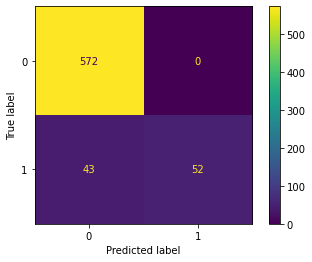

In [99]:
plot_confusion_matrix(forest_new,x_test,y_test,values_format='0.0f')
plt.show()

In [100]:
print('Classification report random forest classifier:\n',classification_report(y_test,forest_new.predict(x_test)))

Classification report random forest classifier:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       572
           1       1.00      0.55      0.71        95

    accuracy                           0.94       667
   macro avg       0.97      0.77      0.84       667
weighted avg       0.94      0.94      0.93       667



#### Экспорт модели

In [56]:
joblib.dump(forest_new,'model')

['model']